In [1]:
using Pkg
Pkg.activate("..")
using Revise
using PythonPlot,Statistics,Distributions,DataFrames,CSV
PythonPlot.svg(true)
using SizeStructuredPopulations
using SpecialFunctions
include("./examples.jl")

methods(generate_cell)

  Activating project at `~/Dartmouth College Dropbox/Ethan Levien/RESEARCH/ACTIVE/SizeStructuredPopulations`
    CondaPkg Found dependencies: /Users/elevien/.julia/packages/PythonCall/WMWY0/CondaPkg.toml
    CondaPkg Found dependencies: /Users/elevien/.julia/packages/PythonPlot/oS8x4/CondaPkg.toml
    CondaPkg Initialising pixi
             │ /Users/elevien/.julia/artifacts/d2fecc2a9fa3eac2108d3e4d9d155e6ff5dfd0b2/bin/pixi
             │ init
             │ --format pixi
             └ /Users/elevien/Dartmouth College Dropbox/Ethan Levien/RESEARCH/ACTIVE/SizeStructuredPopulations/.CondaPkg
✔ Created /Users/elevien/Dartmouth College Dropbox/Ethan Levien/RESEARCH/ACTIVE/SizeStructuredPopulations/.CondaPkg/pixi.toml
    CondaPkg Wrote /Users/elevien/Dartmouth College Dropbox/Ethan Levien/RESEARCH/ACTIVE/SizeStructuredPopulations/.CondaPkg/pixi.toml
             │ [dependencies]
             │ matplotlib = ">=1"
             │ 
             │     [dependencies.python]
             │     ch

# 1 method for generic function "generate_cell" from SizeStructuredPopulations:
 [1] generate_cell(model::GrowthModel, init::Vector{Float64}, Tmax::Float64; dt)
     @ ~/Dartmouth College Dropbox/Ethan Levien/RESEARCH/ACTIVE/SizeStructuredPopulations/src/model.jl:26

In [ ]:
# seed the random number generator for reproducibility
Random.seed!(1234);
model = GrowthModel(M1()...)
init = vcat([0.0], [0.0, 0.0], zeros(3))
T = 1000.0
dt = 0.01
Tmax = T

function terminate(cell)
    return cell.time[end] > Tmax 
end


dfs = []
for i in 1:500
    cell = simulate_lineage(model, T, init, dt = 0.01);
    df = lineage_to_dataframe(cell);
    df.lineage = fill(i, nrow(df))
    push!(dfs,df)
end
df = vcat(dfs...);


In [ ]:
λ = M1()[1]
df.λ .= λ_vals = [λ(collect(row)) for row in eachrow(df[:,[:x1,:x2,:x3]])];
dt = df.time[2] - df.time[1]
dfR = combine(groupby(df,:lineage),:λ => cumsum => :R,:x1 => :x1,:time => :time)
dfR.R = dfR.R *dt# condtains for each lineage T and x as a function of time

dfR.num = exp.(dfR.R).*dfR.x1
dfR.dum = exp.(dfR.R)
dfR_avg = combine(groupby(dfR,:time),:num => mean => :num, :dum => mean => :dum)
# drop cols with NANA
dfR_avg = dropmissing(dfR_avg)

Row,time,num,dum
,Float64,Float64,Float64
1,0.0,0.0,1.01005
2,0.01,0.000701642,1.02021
3,0.02,0.00110338,1.03047
4,0.03,0.00160108,1.04085
5,0.04,0.000987569,1.05132
6,0.05,0.00135082,1.06189
7,0.06,0.00113808,1.07258
8,0.07,0.00134232,1.08337
9,0.08,0.000839865,1.09427


In [27]:
dfR_avg = dfR_avg[dfR_avg.time .< 500,:]

Row,time,num,dum
,Float64,Float64,Float64
1,0.0,0.0,1.01005
2,0.01,0.000701642,1.02021
3,0.02,0.00110338,1.03047
4,0.03,0.00160108,1.04085
5,0.04,0.000987569,1.05132
6,0.05,0.00135082,1.06189
7,0.06,0.00113808,1.07258
8,0.07,0.00134232,1.08337
9,0.08,0.000839865,1.09427


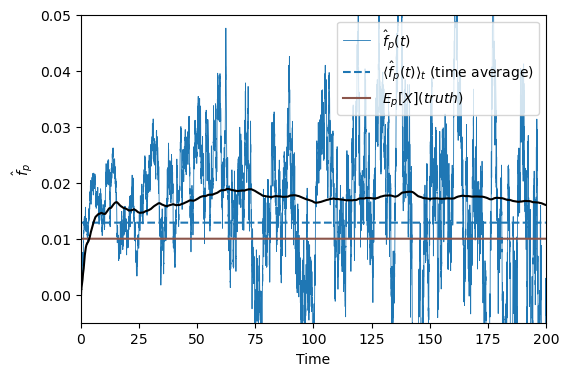

In [42]:
fig,ax = subplots(figsize=(6,4))
u = dfR_avg.num ./ dfR_avg.dum
ax.plot(dfR_avg.time,u,"C0-",alpha=1,lw=0.6,label=L"$\hat{f}_p(t)$")
ax.plot(dfR_avg.time,ones(length(u)).*mean(skipmissing(replace(u, NaN => missing))),"C0--",label=L"$\langle \hat{f}_p(t) \rangle_t$ (time average)")
ax.plot(dfR_avg.time,ones(length(u))*0.01/1,"C5-",label=L"$E_p[X] (truth)$")
# average u over moving window
window = 5000
#u_avg = [mean(u[max(1,i-window+1):i]) for i in 1:length(u)]
u_avg = [mean(u[1:i]) for i in 1:length(u)]#
ax.plot(dfR_avg.time,u_avg,"k-")
ax.set_xlim(-0.1,200)
ax.set_ylim([-0.005,0.05])
ax.set_xlabel("Time")
ax.set_ylabel(L"$\hat{f}_p$")
ax.legend(loc="upper right")
savefig("./fig4.pdf")


fig